In [1]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [ ]:
#!pip install rdkit-pypi

In [4]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [5]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [6]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [7]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [8]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [9]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [10]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [11]:
seq = 'CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'

from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))

c1cccc(COc2cc(-n3nc(OCC)oc3=O)ccc2)c1
c1ccccc1COc1cccc(-n2c(=O)oc(OCC)n2)c1
O=c1oc(OCC)nn1-c1cc(OCc2ccccc2)ccc1
c1c(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cccc1
c1cccc(COc2cccc(-n3c(=O)oc(OCC)n3)c2)c1
c1(=O)n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
c1(COc2cccc(-n3c(=O)oc(OCC)n3)c2)ccccc1
n1c(OCC)oc(=O)n1-c1cc(OCc2ccccc2)ccc1
c1ccc(COc2cccc(-n3nc(OCC)oc3=O)c2)cc1
c1(OCc2ccccc2)cccc(-n2nc(OCC)oc2=O)c1


In [12]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1ccc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)cc1
c1c(OCc2ccccc2)cccc1-n1c(=O)oc(OCC)n1
O(c1cccc(-n2c(=O)oc(OCC)n2)c1)Cc1ccccc1
c1(OCC)oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1c(COc2cc(-n3nc(OCC)oc3=O)ccc2)cccc1
CCOc1nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
c1(-n2nc(OCC)oc2=O)cc(OCc2ccccc2)ccc1
O(c1cccc(-n2c(=O)oc(OCC)n2)c1)Cc1ccccc1
c1(=O)n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
O(CC)c1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [13]:
from datagen import DataGenerator

In [14]:
max_sequence_len

224

In [15]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [16]:
len(dgen) * dgen.batch_size

6160

In [18]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

In [19]:
X_b

array([[21,  2, 28, ...,  0,  0,  0],
       [21, 15, 16, ...,  0,  0,  0],
       [16,  2, 21, ...,  0,  0,  0],
       ...,
       [28,  7, 28, ...,  0,  0,  0],
       [28,  7, 28, ...,  0,  0,  0],
       [28,  7, 28, ...,  0,  0,  0]])

In [20]:
y_b.shape

(13,)

# Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train.shape

(4925,)

In [24]:
X_train = X_train[:4500]
y_train = y_train[:4500]

In [25]:
len(X_train), len(y_train), len(X_test)

(4500, 4500, 1232)

In [26]:
X_train

array(['COc1cc(/C=C/c2ccc3ccccc3[n+]2C)ccc1N1CCOCC1.[I-]',
       'CCCCCCCNC(=O)Oc1ccc2c(c1)C1(C)CCN(CC)C2C1',
       'c1ccc2c(COc3nn(CCN4CCCC4)c4ccccc34)cccc2c1', ...,
       'Cl.Nc1c2c(nc3ccc(F)cc13)CCC2',
       'CCN(CC)CCCCCOc1ccc(C(=O)/C=C/c2ccccc2)cc1',
       'COc1ccccc1/C=C1\\CN(C(=O)C[C@H]2C[C@H]3CCCN3[C@]23C(=O)Nc2ccccc23)C/C(=C\\c2ccccc2OC)C1=O'],
      dtype=object)

In [27]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [28]:
dgen_train

In [29]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

# Network Model

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

In [33]:
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    input_x = Input(shape=(sequence_length,), name='input_x')
    
    # Embedding layer
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=sequence_length)(input_x)
    
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding)
        max_p = MaxPooling1D(pool_size=sequence_length - filter_size + 1)(conv)
        pooled_outputs.append(max_p)
        
    h_pool = Concatenate(axis=2)(pooled_outputs)
    flat = Flatten()(h_pool)
    
    # Dense layers
    dense_units = 256
    dense = Dense(units=dense_units, activation='relu')(flat)
    
    # Output dense layer
    output_layer = Dense(units=1, activation='linear')(dense)
    
    model = Model(inputs=input_x, outputs=output_layer)
    return model

In [34]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict) + 1
embeddings_size = 128 # 2

In [35]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 224)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 224, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 222, 128)     49280       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 221, 128)     65664       ['embedding[0][0]']              
                                                                                              

In [36]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [38]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [52]:
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test)

Epoch 1/100
36/36 [==============================] - 6s 160ms/step - loss: 2.0593 - R2: 0.1584 - val_loss: 1.9899 - val_R2: 0.1995
Epoch 2/100
36/36 [==============================] - 6s 159ms/step - loss: 2.0210 - R2: 0.1703 - val_loss: 1.9543 - val_R2: 0.2091
Epoch 3/100
36/36 [==============================] - 6s 160ms/step - loss: 2.0026 - R2: 0.1826 - val_loss: 1.9255 - val_R2: 0.2188
Epoch 4/100
36/36 [==============================] - 6s 158ms/step - loss: 1.9675 - R2: 0.1953 - val_loss: 1.8935 - val_R2: 0.2284
Epoch 5/100
36/36 [==============================] - 6s 158ms/step - loss: 1.9424 - R2: 0.2074 - val_loss: 1.8642 - val_R2: 0.2449
Epoch 6/100
36/36 [==============================] - 6s 158ms/step - loss: 1.9211 - R2: 0.2138 - val_loss: 1.8348 - val_R2: 0.2527
Epoch 7/100
36/36 [==============================] - 6s 159ms/step - loss: 1.8994 - R2: 0.2226 - val_loss: 1.8096 - val_R2: 0.2688
Epoch 8/100
36/36 [==============================] - 6s 159ms/step - loss: 1.8689 -

In [53]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [54]:
X_test_eval.shape, y_test.shape

((1232, 224), (1232,))

In [55]:
y_pred = model.predict(X_test_eval)

39/39 [==============================] - 0s 12ms/step


# Score

In [56]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [57]:
r2

0.5143971946948698

In [58]:
filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model.save(filename)

# Load model (solo si se grabo el modelo)

In [59]:
from tensorflow.keras.models import load_model

In [60]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [61]:
y_pred = model_loaded.predict(X_test_eval)

39/39 [==============================] - 1s 12ms/step


In [62]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.5143971946948698

# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

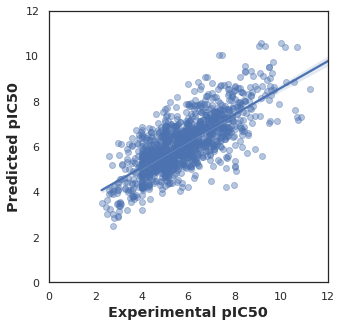

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show